# Heartbeat

This example shows how to use the `BeatData` class to make a dataset for analyzing heartbeats. This class processes the provided ECG records and generates a dataset comprising the extracted heartbeat waveforms, computed features, and their corresponding labels. This type of dataset can be utilized for the heartbeat classification task. For this purpose, any type of machine learning algorithm can be used. The example shows how to include predefined or custom features to the dataset. This requires that an instance of the class `BeatInfo` be passed as an argument.


This example is available on [GitHub](https://github.com/devnums/pyheartlib/blob/main/examples/).

<a target="_blank" href="https://colab.research.google.com/github/devnums/pyheartlib/blob/main/examples/dataset/heartbeat.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install pyheartlib

First, `pyheartlib` needs to be installed.

In [1]:
try:
    import pyheartlib
    print('pyheartlib is already installed')
except ModuleNotFoundError:
    print('Installing pyheartlib...')
    %pip install pyheartlib

pyheartlib is already installed


## Download raw data

`Pyheartlib` supports the WFDB format. A popular dataset that uses this format is the "MIT-BIH Arrhythmia Database". The code below downloads this dataset and stores it in the data directory.

In [2]:
# Download the raw data and store them in the base data directory
from pathlib import Path
if not Path('data').is_dir():
  print('downloading raw data...')
  import io, zipfile
  from urllib.request import urlopen
  url='https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip'
  with urlopen(url) as rs:
      zipf = zipfile.ZipFile(io.BytesIO(rs.read()))
      zipf.extractall('data/')

  # Create the config file. For this example, it will be download from the original repository
  with urlopen("https://raw.githubusercontent.com/devnums/pyheartlib/main/src/pyheartlib/config.yaml") as file:
      content = file.read().decode()
  with open("data/config.yaml", 'w') as file:
      file.write(content)

## Define objects and features

To create a dataset using the `BeatData`, first it needs to be imported.

```python
from pyheartlib.data_beat import BeatData
```

The next step is to create an object of the `pyheartlib.data_beat.BeatData`. 

```python
beatdata = BeatData(
    base_path="data",
    win=[200, 200],
    remove_bl=False,
    lowpass=False,
    progress_bar=False,
)
```
Descriptions of all the parameters of `BeatData` can be found [here](../../introduction.html#directive-bdt).

For feature computation, an instance of the `pyheartlib.beat_info.BeatInfo` has to be created.

```python
from pyheartlib.beat_info import BeatInfo
beatinfo = BeatInfo()
```

`BeatInfo` includes some predefined features, however custom features can also be defined. Each custom feature definition must adhere to this syntax:

```python
def F_new_feature1(self):
    return return_result
```
The `return_result` can be a single number or a dictionary such as {"Feature_1": value_1, "Feature_2": value_2}.

The custom features can be added to the beatinfo object by using the `add_features()` method, the list of all available features can be obtained using the `available_features()` method, and to select desired features for computation the `select_features()` method can be used.

Descriptions of all the parameters of `BeatInfo` can be found [here](../../introduction.html#directive-bif).


In [3]:
from pyheartlib.data_beat import BeatData

# Make an instance of the BeatData
beatdata = BeatData(
    base_path="data",
    win=[200, 200],
    remove_bl=False,
    lowpass=False,
    progress_bar=False,
)

# Make an instance of the BeatInfo
from pyheartlib.beat_info import BeatInfo
beatinfo = BeatInfo()

# Define a custom features. This only returns a single value for demonstration.
# Feature function names has to start with F_
def F_new_feature1(self):
    return 1.09

# Define new features. This function returns two features.
# The feature are returned as dictionary in this case
def F_new_feature2(self):
    post = beatinfo.F_post_rri()
    pre = beatinfo.F_pre_rri()
    ret = {"Post": post, "Pre": pre}
    return ret

# This feature returns the segmented heartbeat waveform.
# bwaveform is computed according to the pre and post RR intervals 
def F_segmented_waveform(self):
    return beatinfo.bwaveform

# Add custom features to the beatinfo object
new_features = [F_new_feature1, F_new_feature2, F_segmented_waveform]
beatinfo.add_features(new_features)

# Get a list of available feature functions which include predefined and custom features
print(beatinfo.available_features())

['F_absmean_sdrri', 'F_beat_kurtosis', 'F_beat_max', 'F_beat_mean', 'F_beat_min', 'F_beat_rms', 'F_beat_skewness', 'F_beat_std', 'F_compensate_diff_nr', 'F_compensate_ratio', 'F_diff_post_avg_nr', 'F_diff_post_pre', 'F_diff_post_pre_nr', 'F_diff_pre_avg_nr', 'F_fft_features', 'F_heart_rate', 'F_maxmin_diff', 'F_maxmin_diff_norm', 'F_mean_pre_rri', 'F_mean_pre_sdrri', 'F_mean_sdrri', 'F_median_rri', 'F_new_feature1', 'F_new_feature2', 'F_nsampels', 'F_post_rri', 'F_pre_rri', 'F_ratio_post_pre', 'F_ratio_post_rms', 'F_ratio_pre_rms', 'F_rms_rri', 'F_rms_sdrri', 'F_segmented_waveform', 'F_std_rri', 'F_std_sdrri', 'F_subsegs']


In [4]:
# Select the desired features
beatinfo.select_features(
    ["F_segmented_waveform", "F_beat_max", "F_beat_skewness", "F_new_feature1", "F_new_feature2"]
)

### Create inter-patient dataset

Finally, using the `save_dataset_inter()` method of `BeatData`, an inter-patient dataset can be created.

In [5]:
# Use the save_dataset_inter method to create an inter-patient dataset.
# The file will be saved in the base data directory.
beatdata.save_dataset_inter(["209"], beatinfo, file="train.beat")

# In a similar way for validation and test datasets
beatdata.save_dataset_inter(["215", "220"], beatinfo, file="val.beat")
beatdata.save_dataset_inter(["103"], beatinfo, file="test.beat")

File saved at: data/train.beat
File saved at: data/val.beat
File saved at: data/test.beat


In [6]:
# Load the datasets
train_ds = beatdata.load_data(file_name="train.beat")
val_ds = beatdata.load_data(file_name="val.beat")
test_ds = beatdata.load_data(file_name="test.beat")

File loaded from: data/train.beat
-Shape of "waveforms" is (2985, 400). Number of samples is 2985.
-Shape of "beat_feats" is (2985, 6). Number of samples is 2985.
-Shape of "labels" is (2985,). Number of samples is 2985.
               N  L  R  j  e  V  E    A  S  a  J  F  f  /  Q
train.beat  2601  0  0  0  0  1  0  383  0  0  0  0  0  0  0

File loaded from: data/val.beat
-Shape of "waveforms" is (5371, 400). Number of samples is 5371.
-Shape of "beat_feats" is (5371, 6). Number of samples is 5371.
-Shape of "labels" is (5371,). Number of samples is 5371.
             N  L  R  j  e    V  E   A  S  a  J  F  f  /  Q
val.beat  5109  0  0  0  0  164  0  97  0  0  0  1  0  0  0

File loaded from: data/test.beat
-Shape of "waveforms" is (2064, 400). Number of samples is 2064.
-Shape of "beat_feats" is (2064, 6). Number of samples is 2064.
-Shape of "labels" is (2064,). Number of samples is 2064.
              N  L  R  j  e  V  E  A  S  a  J  F  f  /  Q
test.beat  2062  0  0  0  0  0  0  2  

229


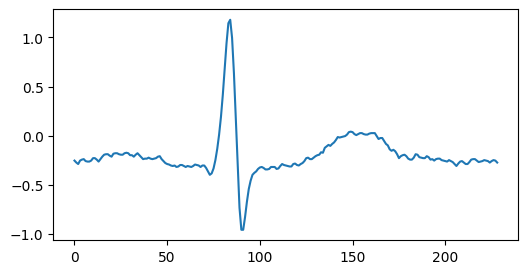

In [7]:
# Plot a hearbeat waveform
wf = train_ds["beat_feats"]["F_segmented_waveform"].iloc[34]
print(len(wf))
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
plt.plot(wf);

In [8]:
# Number of samples per class
stat_report = beatdata.report_stats_table(
    [train_ds["labels"], val_ds["labels"], test_ds["labels"]], ["Train", "Val", "Test"]
)
print(stat_report)

          N  L  R  j  e    V  E    A  S  a  J  F  f  /  Q
Train  2601  0  0  0  0    1  0  383  0  0  0  0  0  0  0
Val    5109  0  0  0  0  164  0   97  0  0  0  1  0  0  0
Test   2062  0  0  0  0    0  0    2  0  0  0  0  0  0  0


In [9]:
print(train_ds["beat_feats"].tail(3))
# The Post and Pre columns are the results of F_new_feature2

                                   F_segmented_waveform  F_beat_max  \
2982  [-0.19, -0.2, -0.2, -0.19, -0.17, -0.17, -0.17...       1.250   
2983  [-0.015, -0.025, -0.04, -0.03, -0.025, -0.015,...       1.355   
2984  [0.135, 0.15, 0.135, 0.125, 0.1, 0.115, 0.135,...       1.420   

      F_beat_skewness  F_new_feature1        Post         Pre  
2982         2.189705            1.09  641.666667  663.888889  
2983         1.755593            1.09  494.444444  641.666667  
2984         2.580627            1.09  761.111111  494.444444  


### Create intra-patient dataset

To create an intra-patient dataset, the `save_dataset_intra` method can be used.

In [10]:
# Use the save_dataset_intra method to create an intra-patient dataset.
# The file will be saved in the base data directory.
beatdata.save_dataset_intra([209, 215], beatinfo)

# Load datasets
train_ds = beatdata.load_data(file_name="intra_train.beat")
test_ds = beatdata.load_data(file_name="intra_test.beat")

File saved at: data/intra_train.beat
File saved at: data/intra_test.beat
File loaded from: data/intra_train.beat
-Shape of "waveforms" is (1897, 400). Number of samples is 1897.
-Shape of "beat_feats" is (1897, 6). Number of samples is 1897.
-Shape of "labels" is (1897,). Number of samples is 1897.
                     N  L  R  j  e   V  E   A  S  a  J  F  f  /  Q
intra_train.beat  1781  0  0  0  0  57  0  59  0  0  0  0  0  0  0

File loaded from: data/intra_test.beat
-Shape of "waveforms" is (4431, 400). Number of samples is 4431.
-Shape of "beat_feats" is (4431, 6). Number of samples is 4431.
-Shape of "labels" is (4431,). Number of samples is 4431.
                    N  L  R  j  e    V  E    A  S  a  J  F  f  /  Q
intra_test.beat  3995  0  0  0  0  108  0  327  0  0  0  1  0  0  0



In [11]:
# Number of samples per class
stat_report = beatdata.report_stats_table(
    [train_ds["labels"], test_ds["labels"]], ["Train", "Test"]
)
print(stat_report)

          N  L  R  j  e    V  E    A  S  a  J  F  f  /  Q
Train  1781  0  0  0  0   57  0   59  0  0  0  0  0  0  0
Test   3995  0  0  0  0  108  0  327  0  0  0  1  0  0  0


In [12]:
print(train_ds['beat_feats'].tail(3))
# The Post and Pre columns are the results of F_new_feature2

                                   F_segmented_waveform  F_beat_max  \
999   [-0.125, -0.11, -0.085, -0.09, -0.12, -0.14, -...       0.885   
1000  [-0.12, -0.135, -0.135, -0.135, -0.13, -0.125,...       0.710   
1001  [-0.135, -0.125, -0.11, -0.13, -0.135, -0.165,...       0.650   

      F_beat_skewness  F_new_feature1        Post         Pre  
999          1.090895            1.09  583.333333  555.555556  
1000         0.565561            1.09  550.000000  583.333333  
1001         0.376462            1.09  566.666667  550.000000  
